<a href="https://colab.research.google.com/github/AntonioJorg/CDR/blob/main/Gerador_CDR_aleatorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import uuid

# --- CONFIGURAÇÃO DA SIMULAÇÃO ---
NUM_ASSINANTES = 200
NUM_ESTACOES_BASE = 6
TOTAL_RECORDS = 5000  # Total de registros de CDR a serem gerados
DIAS_SIMULACAO = 7  # Simular tráfego ao longo de 7 dias

# --- INICIALIZAÇÃO ---
fake = Faker('pt_BR')

# Lista de Estações Rádio Base (ERBs)
ESTACOES_BASE = [f'BS_{i+1}' for i in range(NUM_ESTACOES_BASE)]

# Criar uma lista de assinantes com um "home" ERB para simular localidade
ASSINANTES = []
for _ in range(NUM_ASSINANTES):
    assinante = {
        'msisdn': fake.phone_number(),
        'home_bs': random.choice(ESTACOES_BASE)
    }
    ASSINANTES.append(assinante)

print(f"Simulação iniciada para {NUM_ASSINANTES} assinantes e {NUM_ESTACOES_BASE} estações base.")
print(f"Gerando {TOTAL_RECORDS} registros ao longo de {DIAS_SIMULACAO} dias.")

# --- FUNÇÕES AUXILIARES ---

def get_localizacao_usuario(assinante):
    """
    Simula a localização do usuário.
    Há uma alta probabilidade (80%) de o usuário estar na sua "home" ERB.
    """
    if random.random() < 0.8:
        return assinante['home_bs']
    else:
        return random.choice(ESTACOES_BASE)

def gerar_timestamp_realista(start_date, dias):
    """
    Gera um timestamp aleatório, com maior probabilidade de ocorrer
    durante o dia (8h - 23h) do que na madrugada.
    """
    data = start_date + timedelta(days=random.randint(0, dias - 1))

    # Pondera as horas: mais atividade durante o dia
    horas_ponderadas = list(range(8, 24)) * 5 + list(range(0, 8)) * 1
    hora = random.choice(horas_ponderadas)

    minuto = random.randint(0, 59)
    segundo = random.randint(0, 59)

    return data.replace(hour=hora, minute=minuto, second=segundo)

# --- FUNÇÕES DE GERAÇÃO DE CDR ---

def gerar_cdr_voz(start_time):
    """Gera um registro de CDR para uma chamada de voz."""
    chamador = random.choice(ASSINANTES)
    receptor = random.choice([a for a in ASSINANTES if a != chamador])

    duracao = random.randint(5, 1800) # Duração entre 5 segundos e 30 minutos
    end_time = start_time + timedelta(seconds=duracao)
    status_chamada = random.choices(['ANSWERED', 'BUSY', 'FAILED'], weights=[0.85, 0.1, 0.05], k=1)[0]

    # Se a chamada não for atendida, a duração é muito curta
    if status_chamada != 'ANSWERED':
        duracao = random.randint(1, 10)
        end_time = start_time + timedelta(seconds=duracao)

    return {
        'recordId': str(uuid.uuid4()),
        'recordType': 'VOICE',
        'servedIMSI': chamador['msisdn'],
        'callingNumber': chamador['msisdn'],
        'calledNumber': receptor['msisdn'],
        'startTime': start_time,
        'endTime': end_time,
        'duration': duracao,
        'location': get_localizacao_usuario(chamador),
        'callStatus': status_chamada,
        'dataVolumeUplinkKB': 0,
        'dataVolumeDownlinkKB': 0,
    }

def gerar_cdr_sms(start_time):
    """Gera um registro de CDR para um SMS."""
    remetente = random.choice(ASSINANTES)
    destinatario = random.choice([a for a in ASSINANTES if a != remetente])

    return {
        'recordId': str(uuid.uuid4()),
        'recordType': 'SMS',
        'servedIMSI': remetente['msisdn'],
        'callingNumber': remetente['msisdn'],
        'calledNumber': destinatario['msisdn'],
        'startTime': start_time,
        'endTime': start_time, # SMS é instantâneo
        'duration': 0,
        'location': get_localizacao_usuario(remetente),
        'callStatus': 'N/A',
        'dataVolumeUplinkKB': 0,
        'dataVolumeDownlinkKB': 0,
    }

def gerar_cdr_dados(start_time):
    """Gera um registro de CDR para uma sessão de dados."""
    usuario = random.choice(ASSINANTES)

    duracao = random.randint(60, 7200) # Duração entre 1 minuto e 2 horas
    end_time = start_time + timedelta(seconds=duracao)

    # Volume de dados correlacionado com a duração
    # Simula uma taxa de bits média
    downlink = int(duracao * random.uniform(5, 200)) # KB/s
    uplink = int(downlink * random.uniform(0.1, 0.3)) # Uplink geralmente menor

    return {
        'recordId': str(uuid.uuid4()),
        'recordType': 'DATA',
        'servedIMSI': usuario['msisdn'],
        'callingNumber': None,
        'calledNumber': None,
        'startTime': start_time,
        'endTime': end_time,
        'duration': duracao,
        'location': get_localizacao_usuario(usuario),
        'callStatus': 'N/A',
        'dataVolumeUplinkKB': uplink,
        'dataVolumeDownlinkKB': downlink,
    }

# --- LÓGICA PRINCIPAL DA SIMULAÇÃO ---
lista_de_cdrs = []
data_inicio_simulacao = datetime.now() - timedelta(days=DIAS_SIMULACAO)

for i in range(TOTAL_RECORDS):
    # Escolhe o tipo de registro a ser gerado com base em pesos
    # Ex: 60% de chance de ser dados, 25% voz, 15% SMS
    tipo_registro = random.choices(['DATA', 'VOICE', 'SMS'], weights=[0.60, 0.25, 0.15], k=1)[0]

    # Gera um timestamp para o evento
    timestamp_evento = gerar_timestamp_realista(data_inicio_simulacao, DIAS_SIMULACAO)

    if tipo_registro == 'VOICE':
        cdr = gerar_cdr_voz(timestamp_evento)
    elif tipo_registro == 'SMS':
        cdr = gerar_cdr_sms(timestamp_evento)
    else: # DATA
        cdr = gerar_cdr_dados(timestamp_evento)

    lista_de_cdrs.append(cdr)

    if (i + 1) % 500 == 0:
        print(f"Gerado {i+1}/{TOTAL_RECORDS} registros...")

# --- CRIAÇÃO E EXPORTAÇÃO DO DATAFRAME ---
df_cdr = pd.DataFrame(lista_de_cdrs)

# Ordenar os dados por data de início
df_cdr = df_cdr.sort_values(by='startTime').reset_index(drop=True)

# Formatar a data para melhor legibilidade no CSV
df_cdr['startTime'] = df_cdr['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_cdr['endTime'] = df_cdr['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Salvar em um arquivo CSV
nome_arquivo = 'dataset_cdr_simulado.csv'
df_cdr.to_csv(nome_arquivo, index=False, encoding='utf-8-sig')

print("\n--- Simulação Concluída! ---")
print(f"Dataset salvo como '{nome_arquivo}'")

# Exibir informações e uma amostra do dataset
print("\n--- Amostra do Dataset Gerado ---")
print(df_cdr.head())

print("\n--- Informações do Dataset ---")
print(df_cdr.info())

print("\n--- Distribuição dos Tipos de Registro ---")
print(df_cdr['recordType'].value_counts())

Simulação iniciada para 200 assinantes e 6 estações base.
Gerando 5000 registros ao longo de 7 dias.
Gerado 500/5000 registros...
Gerado 1000/5000 registros...
Gerado 1500/5000 registros...
Gerado 2000/5000 registros...
Gerado 2500/5000 registros...
Gerado 3000/5000 registros...
Gerado 3500/5000 registros...
Gerado 4000/5000 registros...
Gerado 4500/5000 registros...
Gerado 5000/5000 registros...

--- Simulação Concluída! ---
Dataset salvo como 'dataset_cdr_simulado.csv'

--- Amostra do Dataset Gerado ---
                               recordId recordType        servedIMSI  \
0  3b1a2da1-68ce-484e-9a5a-492d3fe1bce6       DATA  +55 31 7780-3694   
1  9cfd40cd-71cb-4d4d-aa80-2d2b3953970a        SMS      31 5145-7181   
2  25083e7f-3186-4631-b65f-9774a9d47b49      VOICE  +55 71 8426 8537   
3  07e7efd4-4810-42af-92e5-a6a68b282ce7       DATA     0800-016-7381   
4  1f92d545-1da8-4348-b5c9-fee4dbdd5ca4       DATA  +55 84 3105-8172   

      callingNumber         calledNumber            star

Com certeza! Criar um simulador de dados de CDR (Call Detail Record) é um excelente exercício. O script abaixo, em Python, irá gerar um conjunto de dados que simula o tráfego de uma pequena rede móvel, conforme sua solicitação.

O script utiliza as bibliotecas pandas para manipulação de dados, faker para gerar números de telefone realistas (no formato brasileiro), e random/numpy para a lógica da simulação.

Estrutura do CDR (Schema)

Baseei a estrutura dos dados nos campos mais comuns encontrados em especificações 3GPP para CDRs, adaptados para a simplicidade da simulação. O schema resultante no arquivo CSV será:

Nome da Coluna	Descrição	Exemplo
recordId	Identificador único para cada registro de CDR.	c6a1b2d3-e4f5-4a67-8b9c-1d2e3f4a5b6c
recordType	Tipo de evento: VOICE, SMS, DATA.	VOICE
servedIMSI	IMSI do assinante que gerou o registro. (Simulado como o nº de telefone)	+55 (81) 98765-4321
callingNumber	Número de quem origina a chamada/SMS.	+55 (81) 98765-4321
calledNumber	Número de quem recebe a chamada/SMS.	+55 (21) 91234-5678
startTime	Data e hora de início do evento (UTC).	2023-10-27 14:30:15
endTime	Data e hora de fim do evento (UTC).	2023-10-27 14:32:45
duration	Duração do evento em segundos.	150
location	ID da Estação Rádio Base (Cell ID) onde o evento foi iniciado.	BS_3
callStatus	Status da chamada (ex: ANSWERED, FAILED, BUSY). N/A para outros tipos.	ANSWERED
dataVolumeUplinkKB	Volume de dados enviados (em KB). Relevante apenas para DATA.	10240
dataVolumeDownlinkKB	Volume de dados recebidos (em KB). Relevante apenas para DATA.	51200
Passo 1: Instalar as Bibliotecas Necessárias

Se você não tiver as bibliotecas, instale-as usando o pip:

Generated bash
pip install pandas faker numpy

Passo 2: O Código Python

Copie e cole o código abaixo em um arquivo chamado gerador_cdr.py.

LER O ARQUIVO CSV - mostrar as linhas e criar uma estatística


In [ ]:
import pandas as pd

# Nome do arquivo gerado
nome_arquivo = 'dataset_cdr_simulado.csv'

# Ler o arquivo CSV para um DataFrame
df_cdr_lido = pd.read_csv(nome_arquivo)

# Mostrar os cinco primeiros registros
print("\n--- Cinco Primeiros Registros do Dataset Lido ---")
display(df_cdr_lido.head())

# Mostrar estatísticas descritivas
print("\n--- Estatísticas Descritivas do Dataset Lido ---")
display(df_cdr_lido.describe())

# Mostrar informações gerais sobre o DataFrame (tipos de dados, non-null counts)
print("\n--- Informações do Dataset Lido ---")
df_cdr_lido.info()


--- Cinco Primeiros Registros do Dataset Lido ---


,recordId,recordType,servedIMSI,callingNumber,calledNumber,startTime,endTime,duration,location,callStatus,dataVolumeUplinkKB,dataVolumeDownlinkKB
0,3b1a2da1-68ce-484e-9a5a-492d3fe1bce6,DATA,+55 31 7780-3694,NaN,NaN,2025-06-21 00:04:32,2025-06-21 01:06:57,3745,BS_6,NaN,127077,728601
1,9cfd40cd-71cb-4d4d-aa80-2d2b3953970a,SMS,31 5145-7181,31 5145-7181,+55 (011) 9189-1391,2025-06-21 00:08:21,2025-06-21 00:08:21,0,BS_2,NaN,0,0
2,25083e7f-3186-4631-b65f-9774a9d47b49,VOICE,+55 71 8426 8537,+55 71 8426 8537,+55 11 9184-6612,2025-06-21 00:17:55,2025-06-21 00:42:23,1468,BS_6,ANSWERED,0,0
3,07e7efd4-4810-42af-92e5-a6a68b282ce7,DATA,0800-016-7381,NaN,NaN,2025-06-21 00:18:01,2025-06-21 00:54:39,2198,BS_3,NaN,37599,201698
4,1f92d545-1da8-4348-b5c9-fee4dbdd5ca4,DATA,+55 84 3105-8172,NaN,NaN,2025-06-21 00:20:38,2025-06-21 01:12:12,3094,BS_2,NaN,15461,72749



--- Estatísticas Descritivas do Dataset Lido ---


,duration,dataVolumeUplinkKB,dataVolumeDownlinkKB
count,5000.00000,5000.00000,5.000000e+03
mean,2389.95460,44840.99620,2.242866e+05
std,2245.31852,63397.94095,2.995224e+05
min,0.00000,0.00000,0.000000e+00
25%,374.00000,0.00000,0.000000e+00
50%,1590.50000,14614.00000,7.601550e+04
75%,4246.00000,69934.50000,3.731352e+05
max,7199.00000,411410.00000,1.378716e+06



--- Informações do Dataset Lido ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   recordId              5000 non-null   object
 1   recordType            5000 non-null   object
 2   servedIMSI            5000 non-null   object
 3   callingNumber         1973 non-null   object
 4   calledNumber          1973 non-null   object
 5   startTime             5000 non-null   object
 6   endTime               5000 non-null   object
 7   duration              5000 non-null   int64 
 8   location              5000 non-null   object
 9   callStatus            1230 non-null   object
 10  dataVolumeUplinkKB    5000 non-null   int64 
 11  dataVolumeDownlinkKB  5000 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


from matplotlib import pyplot as plt
_df_0['duration'].plot(kind='hist', bins=20, title='duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['dataVolumeUplinkKB'].plot(kind='hist', bins=20, title='dataVolumeUplinkKB')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['dataVolumeDownlinkKB'].plot(kind='hist', bins=20, title='dataVolumeDownlinkKB')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='duration', y='dataVolumeUplinkKB', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='dataVolumeUplinkKB', y='dataVolumeDownlinkKB', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['duration'].plot(kind='line', figsize=(8, 4), title='duration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['dataVolumeUplinkKB'].plot(kind='line', figsize=(8, 4), title='dataVolumeUplinkKB')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['dataVolumeDownlinkKB'].plot(kind='line', figsize=(8, 4), title='dataVolumeDownlinkKB')
plt.gca().spines[['top', 'right']].set_visible(False)

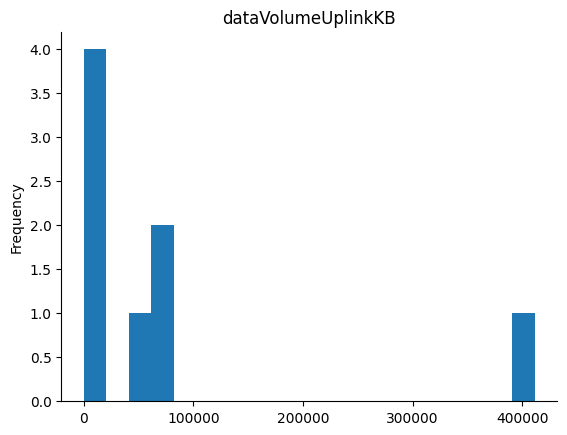

In [ ]:
from matplotlib import pyplot as plt
_df_1['dataVolumeUplinkKB'].plot(kind='hist', bins=20, title='dataVolumeUplinkKB')
plt.gca().spines[['top', 'right',]].set_visible(False)

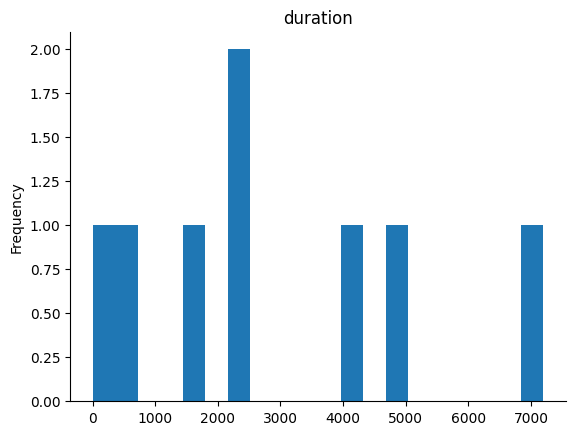

In [ ]:
from matplotlib import pyplot as plt
_df_0['duration'].plot(kind='hist', bins=20, title='duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Análise da Duração das Chamadas de Voz

A partir do dataset simulado `df_cdr_lido`, iremos focar nos registros do tipo 'VOICE' para analisar a distribuição da duração das chamadas. Calcularemos a moda, a mediana e a média da coluna 'duration' para entender as tendências centrais da duração das chamadas de voz na simulação.

In [13]:
# Filtrar o DataFrame para incluir apenas registros de voz
df_voz = df_cdr_lido[df_cdr_lido['recordType'] == 'VOICE'].copy()

# Calcular moda, mediana e média da duração das chamadas de voz
moda_duracao_voz = df_voz['duration'].mode()
mediana_duracao_voz = df_voz['duration'].median()
media_duracao_voz = df_voz['duration'].mean()

print("\n--- Análise da Duração das Chamadas de Voz ---")
print(f"Moda da Duração: {moda_duracao_voz.tolist()}") # mode() pode retornar múltiplos valores
print(f"Mediana da Duração: {mediana_duracao_voz:.2f} segundos")
print(f"Média da Duração: {media_duracao_voz:.2f} segundos")


--- Análise da Duração das Chamadas de Voz ---
Moda da Duração: [9]
Mediana da Duração: 777.00 segundos
Média da Duração: 782.29 segundos


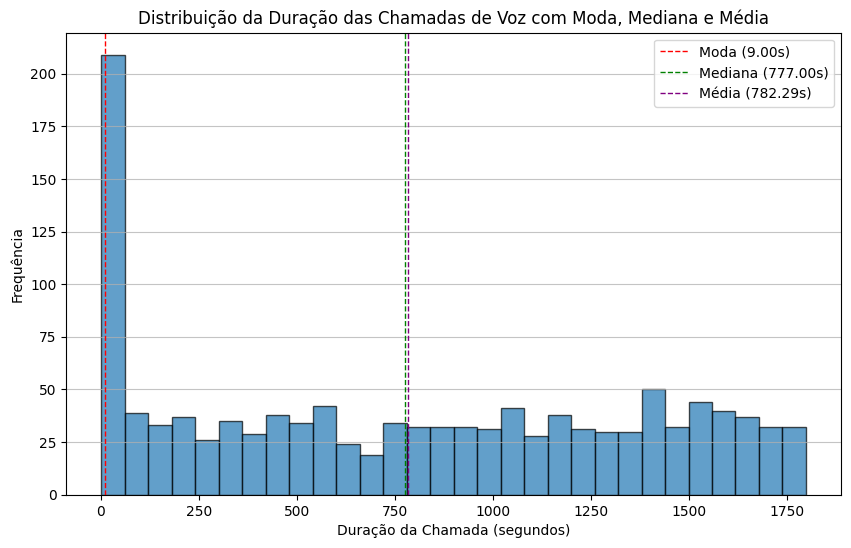

In [14]:
import matplotlib.pyplot as plt

# Crie o histograma da duração das chamadas de voz
plt.figure(figsize=(10, 6))
plt.hist(df_voz['duration'], bins=30, edgecolor='black', alpha=0.7)

# Adicione linhas verticais para moda, mediana e média
# A moda pode ter múltiplos valores, então iteramos sobre eles
for mode_val in moda_duracao_voz:
    plt.axvline(mode_val, color='red', linestyle='dashed', linewidth=1, label=f'Moda ({mode_val:.2f}s)')

plt.axvline(mediana_duracao_voz, color='green', linestyle='dashed', linewidth=1, label=f'Mediana ({mediana_duracao_voz:.2f}s)')
plt.axvline(media_duracao_voz, color='purple', linestyle='dashed', linewidth=1, label=f'Média ({media_duracao_voz:.2f}s)')

# Adicione títulos e rótulos
plt.title('Distribuição da Duração das Chamadas de Voz com Moda, Mediana e Média')
plt.xlabel('Duração da Chamada (segundos)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Mostre o plot
plt.show()

### Análise Estatística das Chamadas de Voz com Duração de Até 50 Segundos

Com o dataset `df_voz` (contendo apenas registros de voz), vamos criar um subconjunto que inclui somente as chamadas com duração igual ou inferior a 50 segundos. Em seguida, realizaremos uma análise estatística descritiva neste novo subconjunto para entender suas características.

In [15]:
# Filtrar chamadas de voz com duração de até 50 segundos
df_voz_curta_duracao = df_voz[df_voz['duration'] <= 50].copy()

# Realizar análise estatística descritiva no subconjunto
print("\n--- Análise Estatística das Chamadas de Voz com Duração de Até 50 Segundos ---")
display(df_voz_curta_duracao.describe())

# Mostrar informações gerais sobre o subconjunto (tipos de dados, non-null counts)
print("\n--- Informações do Subconjunto de Chamadas de Curta Duração ---")
df_voz_curta_duracao.info()

# Mostrar a distribuição dos status de chamada neste subconjunto
print("\n--- Distribuição dos Status de Chamada no Subconjunto de Curta Duração ---")
print(df_voz_curta_duracao['callStatus'].value_counts())


--- Análise Estatística das Chamadas de Voz com Duração de Até 50 Segundos ---


,duration,dataVolumeUplinkKB,dataVolumeDownlinkKB
count,199.000000,199.0,199.0
mean,8.140704,0.0,0.0
std,9.005627,0.0,0.0
min,1.000000,0.0,0.0
25%,3.500000,0.0,0.0
50%,6.000000,0.0,0.0
75%,9.000000,0.0,0.0
max,50.000000,0.0,0.0



--- Informações do Subconjunto de Chamadas de Curta Duração ---
<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 47 to 4920
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   recordId              199 non-null    object
 1   recordType            199 non-null    object
 2   servedIMSI            199 non-null    object
 3   callingNumber         199 non-null    object
 4   calledNumber          199 non-null    object
 5   startTime             199 non-null    object
 6   endTime               199 non-null    object
 7   duration              199 non-null    int64 
 8   location              199 non-null    object
 9   callStatus            199 non-null    object
 10  dataVolumeUplinkKB    199 non-null    int64 
 11  dataVolumeDownlinkKB  199 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 20.2+ KB

--- Distribuição dos Status de Chamada no Subconjunto de Curta Duração ---
callSt

### Análise da Distribuição do Status das Chamadas de Voz

A partir do dataset `df_voz` (contendo todos os registros de voz), vamos analisar a distribuição dos diferentes status de chamada contidos na coluna `callStatus`. Isso nos permitirá ver a frequência de cada status, como 'ANSWERED', 'BUSY', 'FAILED', etc.

In [18]:
# Analisar a distribuição dos status de chamada para todos os registros de voz
print("\n--- Distribuição dos Status de Chamada para Todos os Registros de Voz ---")
print(df_voz['callStatus'].value_counts())


--- Distribuição dos Status de Chamada para Todos os Registros de Voz ---
callStatus
ANSWERED    1015
BUSY         119
FAILED        57
Name: count, dtype: int64


### Análise da Correlação entre Duração e Status da Chamada de Voz

Para verificar se chamadas de curta duração estão mais frequentemente associadas aos status 'BUSY' ou 'FAILED', vamos agrupar o dataset `df_voz` pelo campo `callStatus` e analisar as estatísticas descritivas da duração (`duration`) para cada grupo. Isso nos permitirá comparar as distribuições de duração entre chamadas atendidas, ocupadas e falhas.

In [19]:
# Agrupar o DataFrame de voz por 'callStatus' e descrever a coluna 'duration' para cada grupo
print("\n--- Estatísticas Descritivas da Duração por Status de Chamada ---")
display(df_voz.groupby('callStatus')['duration'].describe())


--- Estatísticas Descritivas da Duração por Status de Chamada ---


,count,mean,std,min,25%,50%,75%,max
callStatus,,,,,,,,
ANSWERED,1015.0,916.964532,527.383868,6.0,455.0,931.0,1394.0,1799.0
BUSY,119.0,5.672269,2.896840,1.0,3.0,5.0,8.0,10.0
FAILED,57.0,5.508772,2.946686,1.0,3.0,6.0,8.0,10.0


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='count', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='std', y='min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='min', y='25%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

In [23]:
from matplotlib import pyplot as plt
_df_voz['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name '_df_voz' is not defined